In [1]:
using Revise

In [2]:
using PyCall, PyPlot, Statistics
using ClimateMARGO
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");

In [3]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting

## Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [4]:
model = ClimateModel(ClimateMARGO.IO.included_configurations["default"])
@time optimize_controls!(model, obj_option = "net_benefit");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 38.714362 seconds (50.54 M allocations: 2.474 GiB, 4.27% gc time)


In [5]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxTnoG" => [], "maxT" => [])
ρdict = Dict()
ρs = 0.:0.0025:0.05

for ρ in ρs
    tmp_model = ClimateModel(ClimateMARGO.IO.included_configurations["default"]);
    tmp_model.economics.ρ = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["maxTnoG"], maximum(T(tmp_model, M=true, R=true)))
    append!(stat_dict["maxT"], maximum(T(tmp_model, M=true, R=true, G=true)))
end

Solve_Succeeded
  0.168968 seconds (117.67 k allocations: 4.382 MiB)
Solve_Succeeded
  0.141854 seconds (121.75 k allocations: 4.467 MiB)
Solve_Succeeded
  0.145163 seconds (117.81 k allocations: 4.391 MiB)
Solve_Succeeded
  0.121460 seconds (117.81 k allocations: 4.391 MiB)
Solve_Succeeded
  0.088728 seconds (109.78 k allocations: 4.229 MiB)
Solve_Succeeded
  0.099298 seconds (105.99 k allocations: 4.163 MiB)
Solve_Succeeded
  0.104209 seconds (102.05 k allocations: 4.086 MiB)
Solve_Succeeded
  0.100516 seconds (98.11 k allocations: 4.010 MiB)
Solve_Succeeded
  0.145340 seconds (103.30 k allocations: 4.292 MiB, 25.66% gc time)
Solve_Succeeded
  0.076903 seconds (94.02 k allocations: 3.925 MiB)
Solve_Succeeded
  0.072302 seconds (94.17 k allocations: 3.935 MiB)
Solve_Succeeded
  0.072956 seconds (94.02 k allocations: 3.925 MiB)
Solve_Succeeded
  0.084293 seconds (90.23 k allocations: 3.859 MiB)
Solve_Succeeded
  0.092070 seconds (90.08 k allocations: 3.849 MiB)
Solve_Succeeded
  0.0673

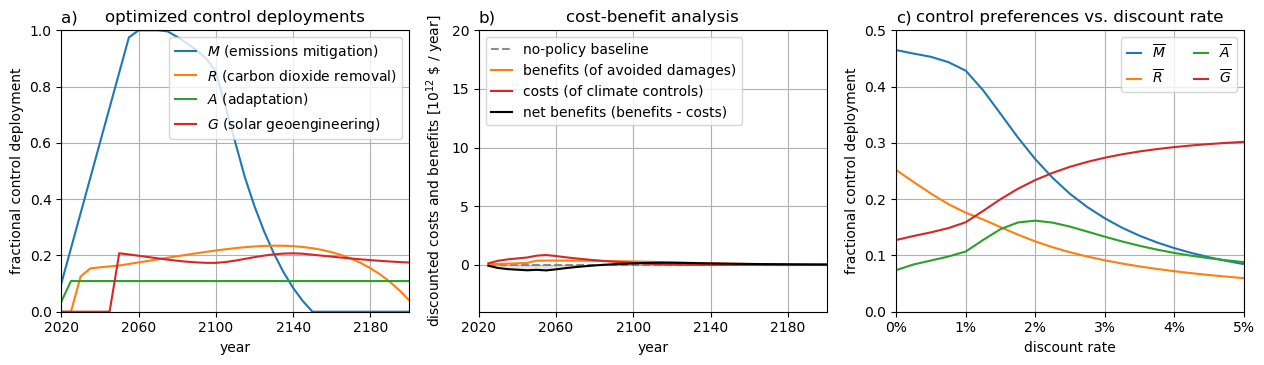

Maximum warming: 1.4175477873553717

In [6]:
fig = figure(figsize=(12.75,3.75))

fig.add_subplot(1,3,1)
plot_controls(model)
legend(handlelength=1.5, loc="upper right")
title("a)", loc="left")
xticks(t(model)[1]:40.:2200.)

ax = fig.add_subplot(1,3,2)
plot_benefits(model)
legend(handlelength=1.5, loc="upper left")
title("b)", loc="left")
ylim([-4., 20.])
xticks(t(model)[1]:40.:2200.)

ax = fig.add_subplot(1,3,3)
plot(ρs, stat_dict["mitigate"], label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], label=L"$\overline{G}$")
legend(ncol=2, handlelength=1.)
ylim([0, 0.5])
xlim([0., 0.05])
xticks([0., 0.01, 0.02, 0.03, 0.04, 0.05], ["0%", "1%", "2%", "3%", "4%", "5%"])
grid(true)
ylabel("fractional control deployment")
title("control preferences vs. discount rate")
title("c)", loc="left")
xlabel("discount rate")

tight_layout()
savefig("../../figures/default-benefits_controls_and_benefits.pdf", dpi=150, bbox_inches="tight")

print("Maximum warming: ", maximum(T(model, M=true, R=true, G=true, A=true)))

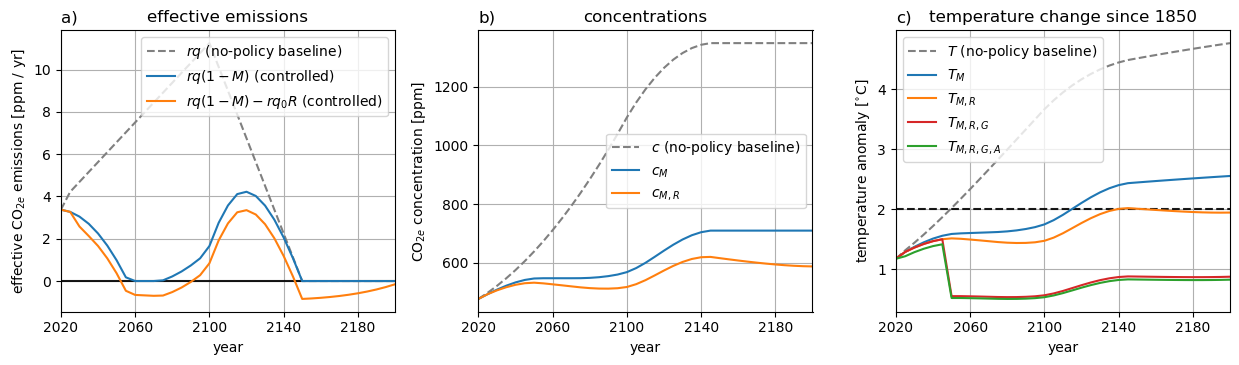

In [7]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
title("a)", loc="left")
subplot(1,3,2)
plot_concentrations(model)
legend()
title("b)", loc="left")
subplot(1,3,3)
plot_temperatures(model)
legend(loc="upper left")
title("c)", loc="left")
tight_layout()
savefig("../../figures/SI_default-temp_carbon_and_temperatures_cost-benefit.pdf", dpi=150, bbox_inches="tight")

#### Approach 2: Avoiding damage thresholds

In [13]:
model = ClimateModel(ClimateMARGO.IO.included_configurations["default"])
@time optimize_controls!(model);

Solve_Succeeded
  0.099166 seconds (129.71 k allocations: 4.829 MiB)


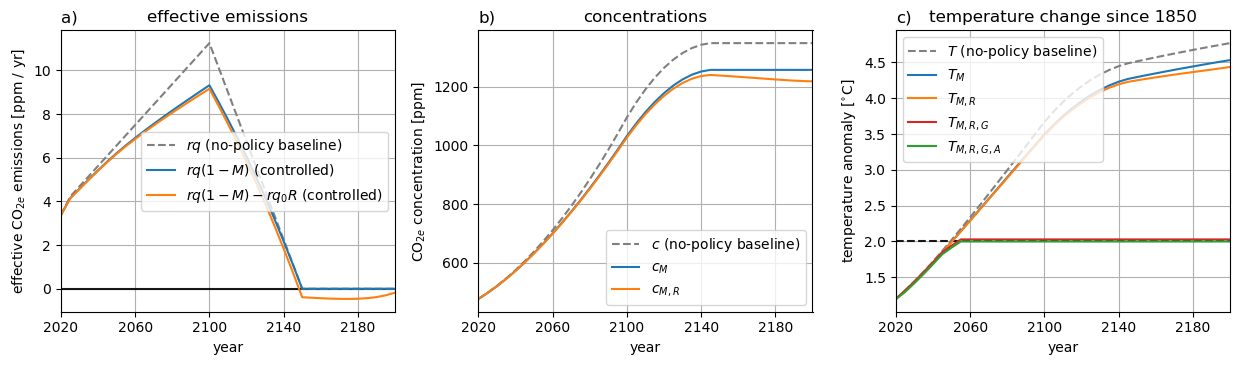

In [14]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
title("a)", loc="left")
subplot(1,3,2)
plot_concentrations(model)
legend()
title("b)", loc="left")
subplot(1,3,3)
plot_temperatures(model)
legend(loc="upper left")
title("c)", loc="left")
tight_layout()
savefig("../../figures/default-temp_carbon_and_temperatures.pdf", dpi=150, bbox_inches="tight")

In [15]:
function f_asymp(α, μ)
    return α .^ 2. ./ (1. .- exp.(-(1 .- α)/(1. - μ)))
end
α = 0.:0.002:1.0

0.0:0.002:1.0

In [16]:
μ = 0.4
tmp_model = ClimateModel(ClimateMARGO.IO.included_configurations["default"]);
@time m = optimize_controls!(
    tmp_model,
    mitigation_penetration = μ,
);


Solve_Succeeded
  0.093434 seconds (131.15 k allocations: 4.914 MiB)


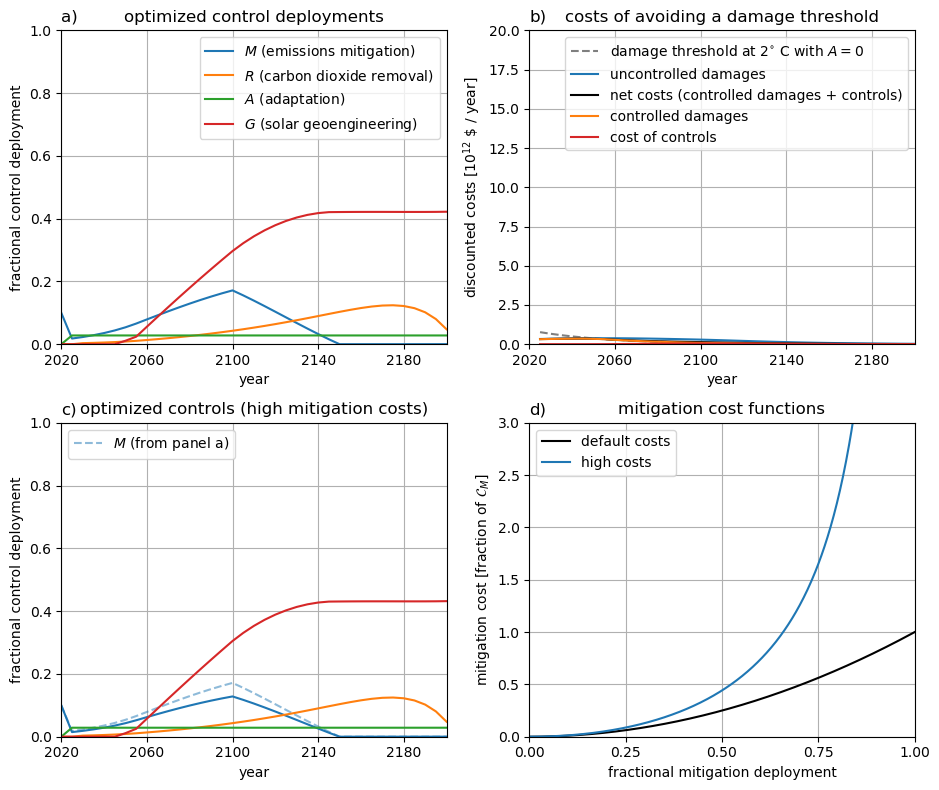

Net Present Control Costs: 0.0

In [17]:
figure(figsize=(9.5,8))

subplot(2,2,1)
plot_controls(model)
legend(loc="upper right")
title("a)", loc="left")

subplot(2,2,2)
plot_damages(model)
legend(loc="upper right")
title("b)", loc="left")
ylim([0, 20])

subplot(2,2,3)
plot(t(model), model.controls.mitigate, "C0--", alpha=0.5, label=L"$M$ (from panel a)")
legend(loc="upper left")
plot_controls(tmp_model)
title("c)", loc="left")
title("optimized controls (high mitigation costs)")

subplot(2,2,4)
plot(α, α.^2, "k-", label="default costs")
plot(α, f_asymp(α, μ), label="high costs")
xlim([0,1])
ylim([0,3])
xticks([0., 0.25, 0.5, 0.75, 1.])
legend(loc="upper left")
ylabel(L"mitigation cost [fraction of $\mathcal{C}_{M}$]")
xlabel("fractional mitigation deployment")
title("mitigation cost functions")
title("d)", loc="left")
grid(true)

tight_layout()
savefig("../../figures/default-temp_controls_and_damages.pdf", dpi=150, bbox_inches="tight")

print("Net Present Control Costs: ", net_present_cost(model))